<a href="https://colab.research.google.com/github/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/Dataset_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center">Airborne Object Tracking Dataset</h1>
<h2 style="text-align:center;text-decoration:underline;">Dataset Walkthrough</h2>

# 🤫 Setting up

In [1]:
import json
import random
import os, sys
from IPython.display import display, clear_output, HTML
from random import randrange, choice
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
import numpy as np
import seaborn as sns

# Because Life, Universe and Everything!
random.seed(42)

def mdprint(text):
    display({
        'text/markdown': text,
        'text/plain': text
    }, raw=True)

!git clone https://github.com/VuongTuanKhanh/Funix-Capstone-Project.git

os.mkdir("Funix-Capstone-Project/data")
os.chdir("Funix-Capstone-Project/data")

Cloning into 'Funix-Capstone-Project'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 82 (delta 25), reused 69 (delta 16), pack-reused 0
Unpacking objects: 100% (82/82), done.


# ⏱ Loading the Dataset

## 🚕 Dataset Walkthrough using AOT Starter Kit

**NOTE**: You don't need to have `groundtruth.json` pre-downloaded, it will automatically download, save and load them for you.

In [2]:
# Dataset for Airborne Object Tracking Dataset
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())) + "/core")

!pip install -r ../requirements.txt > /dev/null

from core.dataset import Dataset
notebook_path = os.path.dirname(os.path.realpath("__file__"))

local_path = notebook_path + '/part1'
s3_path = 's3://airborne-obj-detection-challenge-training/part1/'
dataset = Dataset(local_path, s3_path, partial=True, prefix='part1')
clear_output()

In [3]:
from core.dataset import Dataset

# Dataset is automatically downloaded to this folder
notebook_path = os.path.dirname(os.path.realpath("__file__")) + '/data'
# Location to look for images in case they aren't present locally
s3_path = 's3://airborne-obj-detection-challenge-training'

# Generate the constructer of the Dataset instance
dataset = Dataset(partial=True)

# Add parts to the Dataset
for prefix in ['/part1', '/part2', '/part3']:
    path = notebook_path + prefix
    # Append the second part of the dataset
    dataset.add(path, s3_path + prefix, prefix)
    
# Clear the output
clear_output()

This equal to the below code base:

```python
from core.dataset import Dataset
dataset = Dataset(local_path='data/part1', s3_path='s3://airborne-obj-detection-challenge-training/part1/', prefix='part1', partial=True)
dataset.add(local_path='data/part2', s3_path='s3://airborne-obj-detection-challenge-training/part2/', prefix='part2', partial=True)
dataset.add(local_path='data/part3', s3_path='s3://airborne-obj-detection-challenge-training/part3/', prefix='part3', partial=True)
```

## 🚗 Dataset Walkthrough using EFS

The **Encrypting File System (EFS)** is a feature of the **Windows 2000** operating system that lets any file or folder be stored in encrypted form and decrypted only by an individual user and an authorized recovery agent. **EFS** is especially useful for mobile computer users, whose computer (and files) are subject to physical theft, and for storing highly sensitive data.

**EFS** simply makes encryption an attribute of any file or folder. To store and retrieve a file or folder, a user must request a key from a program that is built into **Windows 2000**.

Although an encrypting file system has existed in or been an add-on to other operating systems, its inclusion in **Windows 2000** is expected to bring the idea to a larger audience.

In this research, I would also like to mention and demo the use of **EFS** for storing and downloading datasets.

In [4]:
# Check whether efs-data folder is existed and not empty
# Install the nfs tree
!apt install nfs-common tree

if not os.path.exists("./efs-data"):
    # Create the directory
    os.mkdir("efs-data")

# Mounting the data to the created directory
!sudo mount -t nfs -o nfsvers=4.1,rsize=1048576,wsize=1048576,hard,timeo=600,retrans=2 airborne-object-tracking-dataset.aicrowd.com:/ efs-data/
# Print out the structure of the downloaded folder
!tree -L 3 efs-data/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  keyutils libnfsidmap2 libtirpc1 rpcbind
Suggested packages:
  open-iscsi watchdog
The following NEW packages will be installed:
  keyutils libnfsidmap2 libtirpc1 nfs-common rpcbind tree
0 upgraded, 6 newly installed, 0 to remove and 40 not upgraded.
Need to get 439 kB of archives.
After this operation, 1,468 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 keyutils amd64 1.5.9-9.2ubuntu2 [47.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libnfsidmap2 amd64 0.25-5.1 [27.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libtirpc1 amd64 0.2.5-1.2ubuntu0.1 [75.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main

## 🌱 Ground Truth Structure

Ground truth (present in `ImageSets` folder) contains all the relevant information regarding airborne objects, their locations, bbox and so on.
While the `Images` folder have accompanied images for your training code to work on.

Before we start, let's check the vocabulary we will need to understand the dataset:

* `flights` (a.k.a. `samples` in ground truth):<br>
  One flight is typically 2 minutes video at 10 fps i.e. 1200 images. Each of the frames are present in `Images/{{flight_id}}/` folder. These files are typically 3-4mb each.


* `frame` (a.k.a. `entity` in ground truth):<br>
  This is the most granular unit on which dataset can be sampled. Each frame have information timestamp, frame_id, and label `is_above_horizon`.
  There can be multiple entries for same frame in `entity` when multiple Airborne objects are present.<br>
  When an Airborne object following information is available as well:
  - `id` -> signifies unique ID of this object (for whole frame)
  - `bbox` -> it contains 4 floats signifying `[left, top, width, height]`
  - `blob['range_distance_m']` -> distance of airborne object
  - `labels['is_above_horizon']` -> details below
  - (derived) `planned` -> for the planned objects `range_distance_m` is available
    

* `is_above_horizon`:<br>
  It is marked as 1 when Airborne object is above horizon and -1 when it is below horizon. When unclear, it is marked as 0.

Example for frame level data (multiple per frame):

```json
{
    'time': 1550844897919368155,
    'blob': {
        'frame': 480,
        'range_distance_m': nan # signifies, it was an unplanned object
    },
    'id': 'Bird2',
    'bb': [1013.4, 515.8, 6.0, 6.0],
    'labels': {'is_above_horizon': 1},
    'flight_id': '280dc81adbb3420cab502fb88d6abf84',
    'img_name': '1550844897919368155280dc81adbb3420cab502fb88d6abf84.png'
}
```

# 👀 DeepDive into Flight



In [5]:
all_flight_ids = dataset.get_flight_ids()
lucky_flight_id = random.choice(all_flight_ids)
lucky_flight = dataset.get_flight_by_id(lucky_flight_id)

mdprint("## 🔮Lucky draw tells us to continue with: `%s`" % lucky_flight_id)

mdprint("### Let's know our flight a bit more! 🔎")
print(lucky_flight)

mdprint("This flight has **%s frames** and total **%s airborne objects**." % (lucky_flight.num_frames, lucky_flight.num_airborne_objs))

mdprint("List of Airborne Objects: ")
for airborne_obj in lucky_flight.get_airborne_objects():
    mdprint("- %s " % airborne_obj)

assert lucky_flight.num_airborne_objs > 0, "Unlucky draw; this flight sequence have 0 airborne objects; please re-run this cell"

## 🔮Lucky draw tells us to continue with: `part366551f5f056f4215abae4a6410f17585`

### Let's know our flight a bit more! 🔎

Flight#part366551f5f056f4215abae4a6410f17585(num_frames=34, num_airborne_objs=2)


This flight has **34 frames** and total **2 airborne objects**.

List of Airborne Objects: 

- AirborneObject#Helicopter1(num_frames=34, planned=True) 

- AirborneObject#Bird1(num_frames=18, planned=False) 

### 🛫 We know text content isn't lucrative, no?!

#### 💾 Download whole dataset (optional)

Please note, **downloading image for each frame** would be slower, so when using for training downloading whole dataset is preferred. 

You can download full dataset using following command in your directory:

```
aws s3 sync s3://airborne-obj-detection-challenge-training/part1 part1/ --no-sign-request
aws s3 sync s3://airborne-obj-detection-challenge-training/part1 part2/ --no-sign-request
aws s3 sync s3://airborne-obj-detection-challenge-training/part1 part3/ --no-sign-request
```

#### 💾 Download whole flight (optional)

**NOTE:**
Each flight is roughly 3-5GB in size, due to which it will take time to download. The dataset helper scripts _can_ be run without downloading dataset as well, so you can skip below download in case you hate waiting! :)

You can download individual flight using below command:

```
aws s3 sync s3://airborne-obj-detection-challenge-training/part1/Images/{{flight_id}} part1/Images/{{flight_id}} --no-sign-request
```

or:


In [ ]:
# (optional) can take upto 5-10 mins on Colab
lucky_flight.download()

#### 🌤 Let's quickly check how the scenery looks like in this video

2021-08-24 12:48:44.823 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/66551f5f056f4215abae4a6410f17585/156611319923509927066551f5f056f4215abae4a6410f17585.png


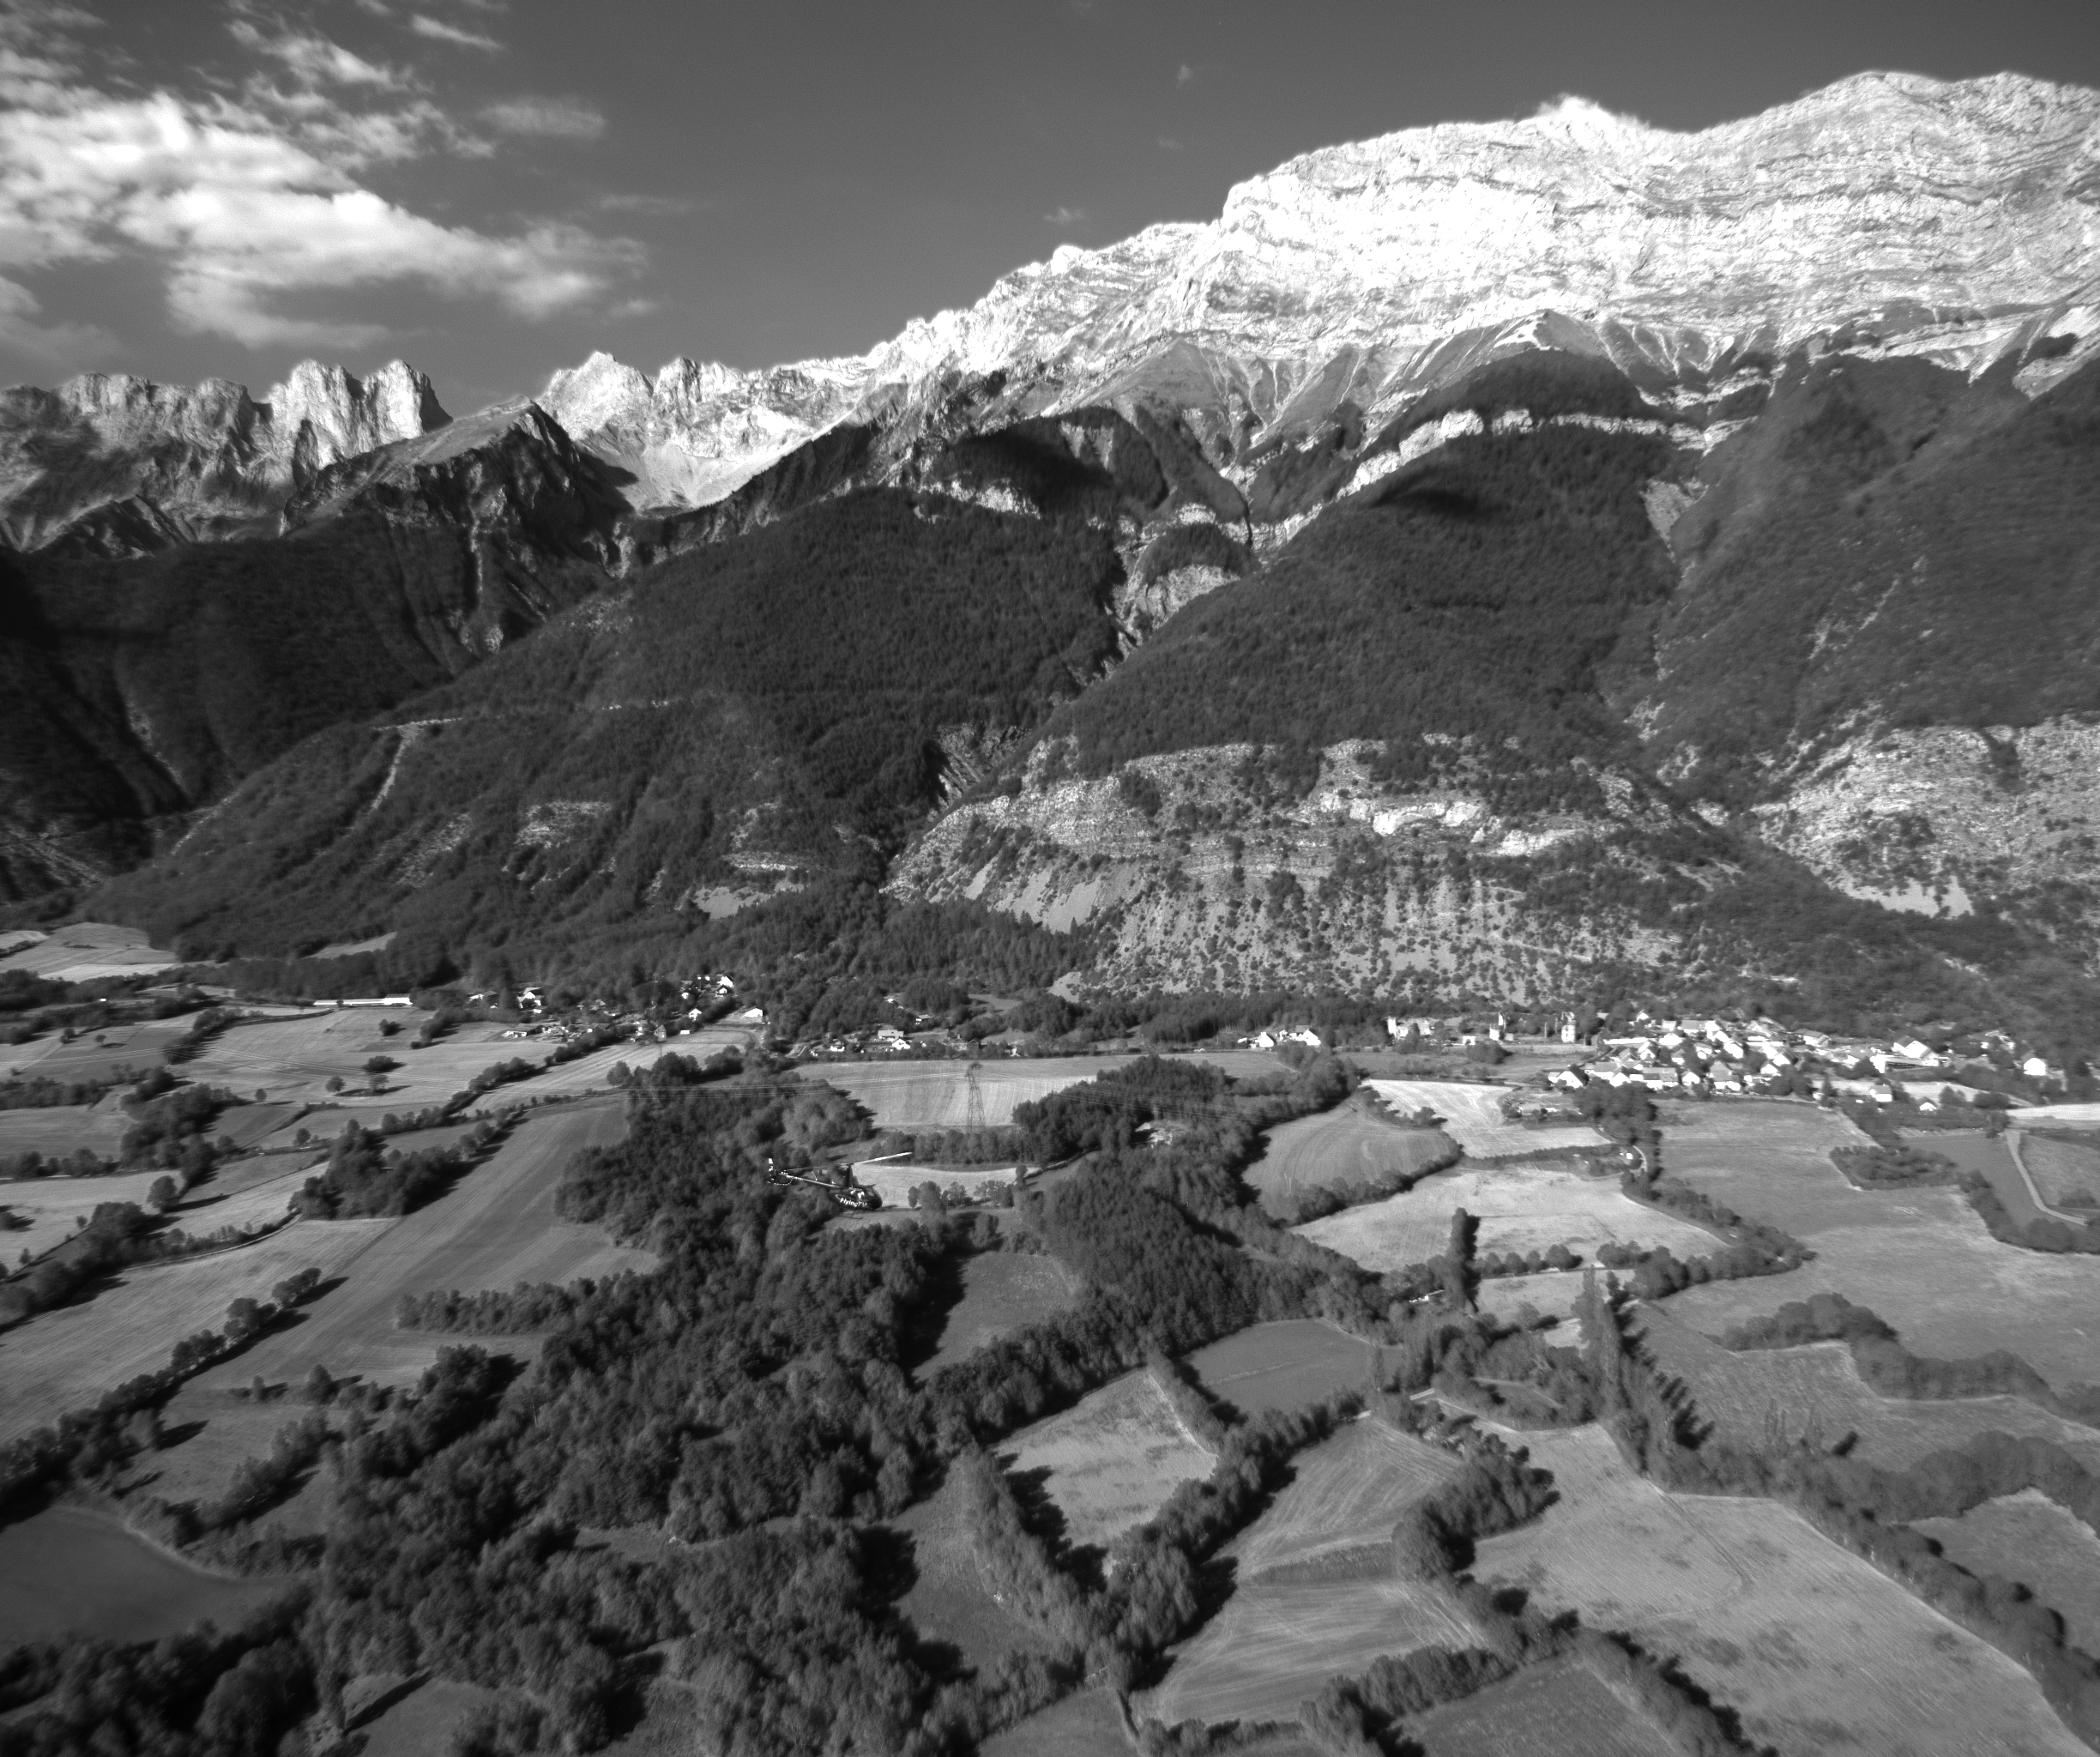

In [6]:
image = lucky_flight.get_frame(choice(list(lucky_flight.frames.keys()))).image()
display(image)

#### 🖼️Well, one picture doesn't give much idea, let's try out few frames (n=9) 
_You can try out whole video as well if you have dataset downloaded_

2021-08-24 12:48:58.383 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/66551f5f056f4215abae4a6410f17585/156611319930988704966551f5f056f4215abae4a6410f17585.png
2021-08-24 12:48:58.805 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/66551f5f056f4215abae4a6410f17585/156611319761407504166551f5f056f4215abae4a6410f17585.png
2021-08-24 12:48:59.186 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/66551f5f056f4215abae4a6410f17585/156611319733465764666551f5f056f4215abae4a6410f17585.png
2021-08-24 12:48:59.612 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/66551f5f056f4215abae4a6410f17585/156611320001237552666551f5f056f4215abae4a6410f17585.png
2021-08-24 12:48:59.979 | INFO     | core.file_handler:d

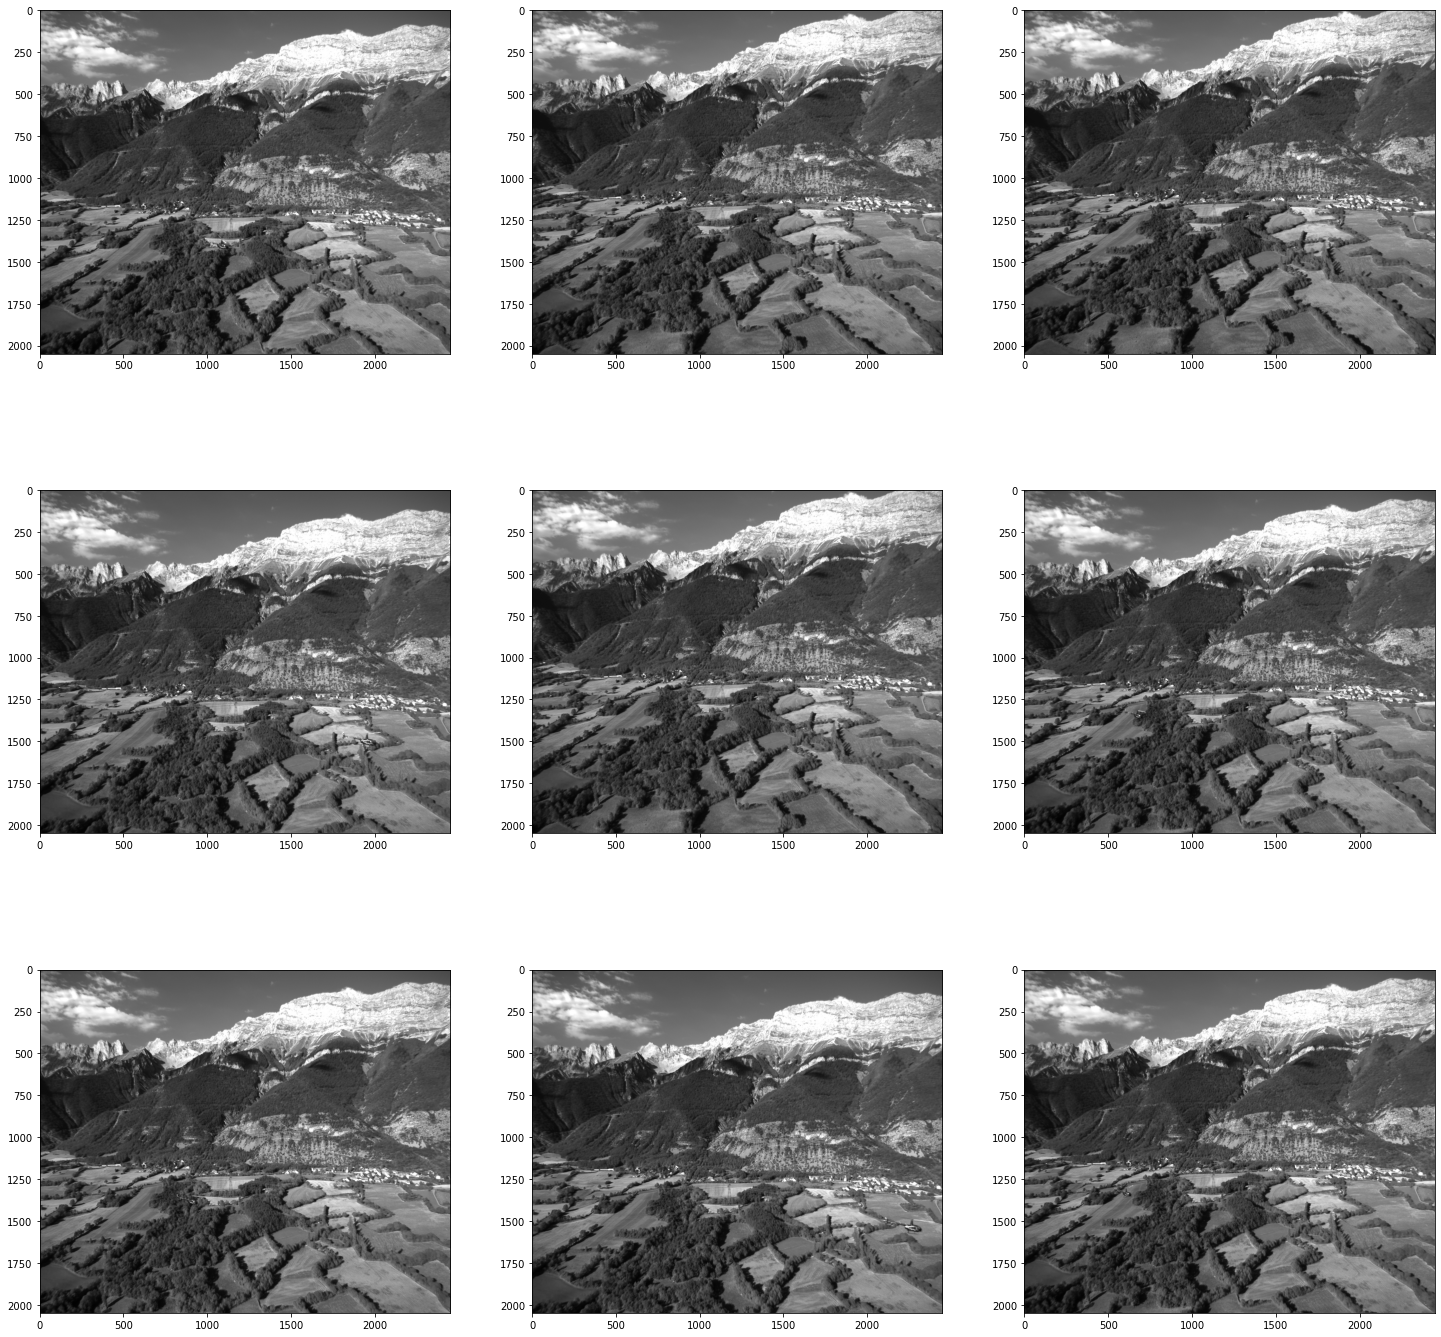

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
fig = plt.figure()

for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    ax.imshow(lucky_flight.get_frame(choice(list(lucky_flight.frames.keys()))).image(type='cv2'))

plt.show()

#### 📉 Presence of the objects and distance in frames (when present)

<Figure size 2000x2000 with 0 Axes>

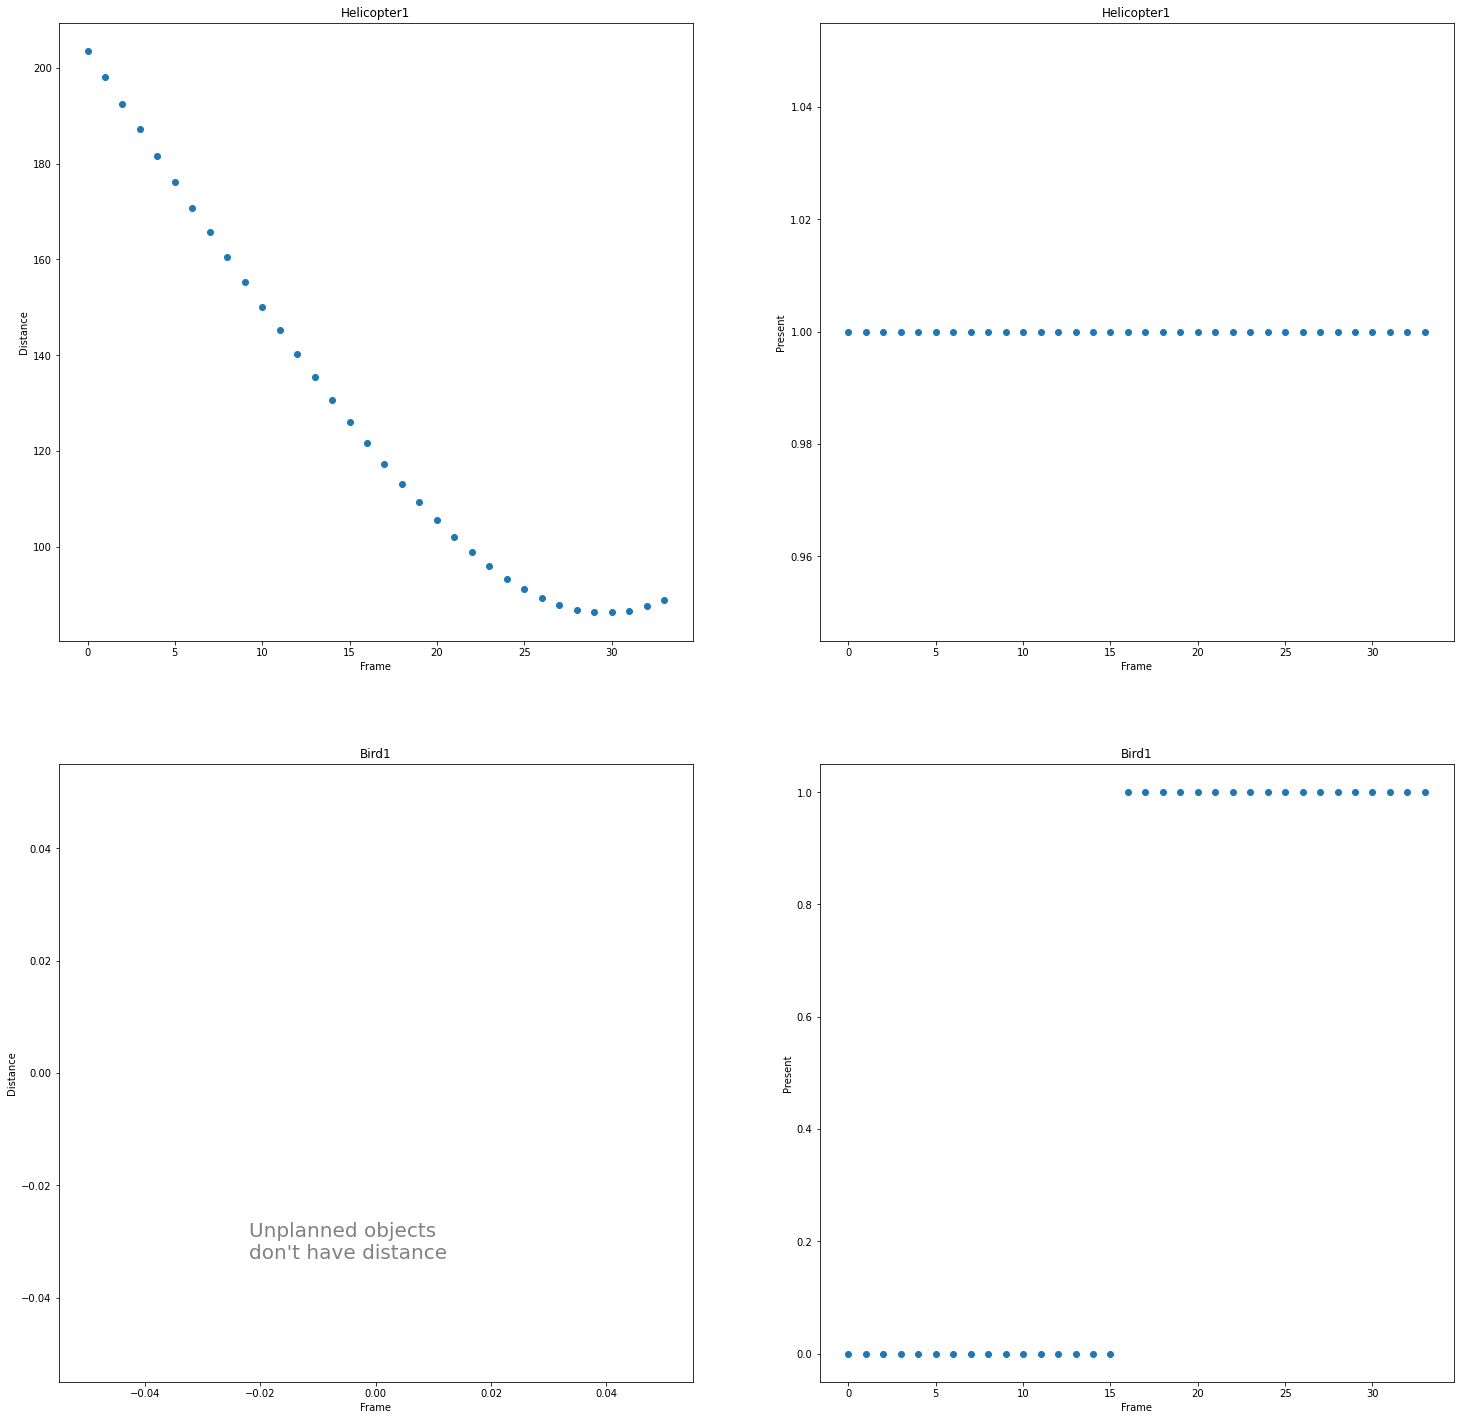

None

In [8]:
airborne_objects = lucky_flight.detected_objects
frames = lucky_flight.frames

rows = len(airborne_objects.keys())

detected = {}
distance = {}
for frame_id in lucky_flight.frames:
    f = lucky_flight.get_frame(frame_id)
    for obj in airborne_objects:
        if obj not in detected:
            detected[obj] = []
            distance[obj] = []

        if obj in f.detected_objects:
            detected[obj].append(True)
            distance[obj].append(f.detected_object_locations[obj].range_distance_m)
        else:
            detected[obj].append(False)
            if not airborne_objects[obj].planned:
                distance[obj].append(float("NaN"))
            else:
                distance[obj].append(0)

i = 0
f = plt.figure(figsize=(25, 25), dpi=80)
f, axes = plt.subplots(nrows = rows, ncols = 2, squeeze=False)

for obj in detected:
    axes[i][0].scatter(range(len(distance[obj])), distance[obj])
    axes[i][0].set_xlabel('Frame')
    axes[i][0].set_ylabel('Distance')
    axes[i][0].set_title(obj)
    
    if not airborne_objects[obj].planned:
        plt.text(0.3, 0.2, "Unplanned objects\ndon't have distance", 
                 fontsize=20, transform=axes[i][0].transAxes, color="grey")

    axes[i][1].scatter(range(len(detected[obj])), detected[obj])
    axes[i][1].set_xlabel('Frame')
    axes[i][1].set_ylabel('Present')
    axes[i][1].set_title(obj)
    i += 1
    
display(plt.show())

2021-08-24 12:49:25.829 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/66551f5f056f4215abae4a6410f17585/156611319743428796466551f5f056f4215abae4a6410f17585.png


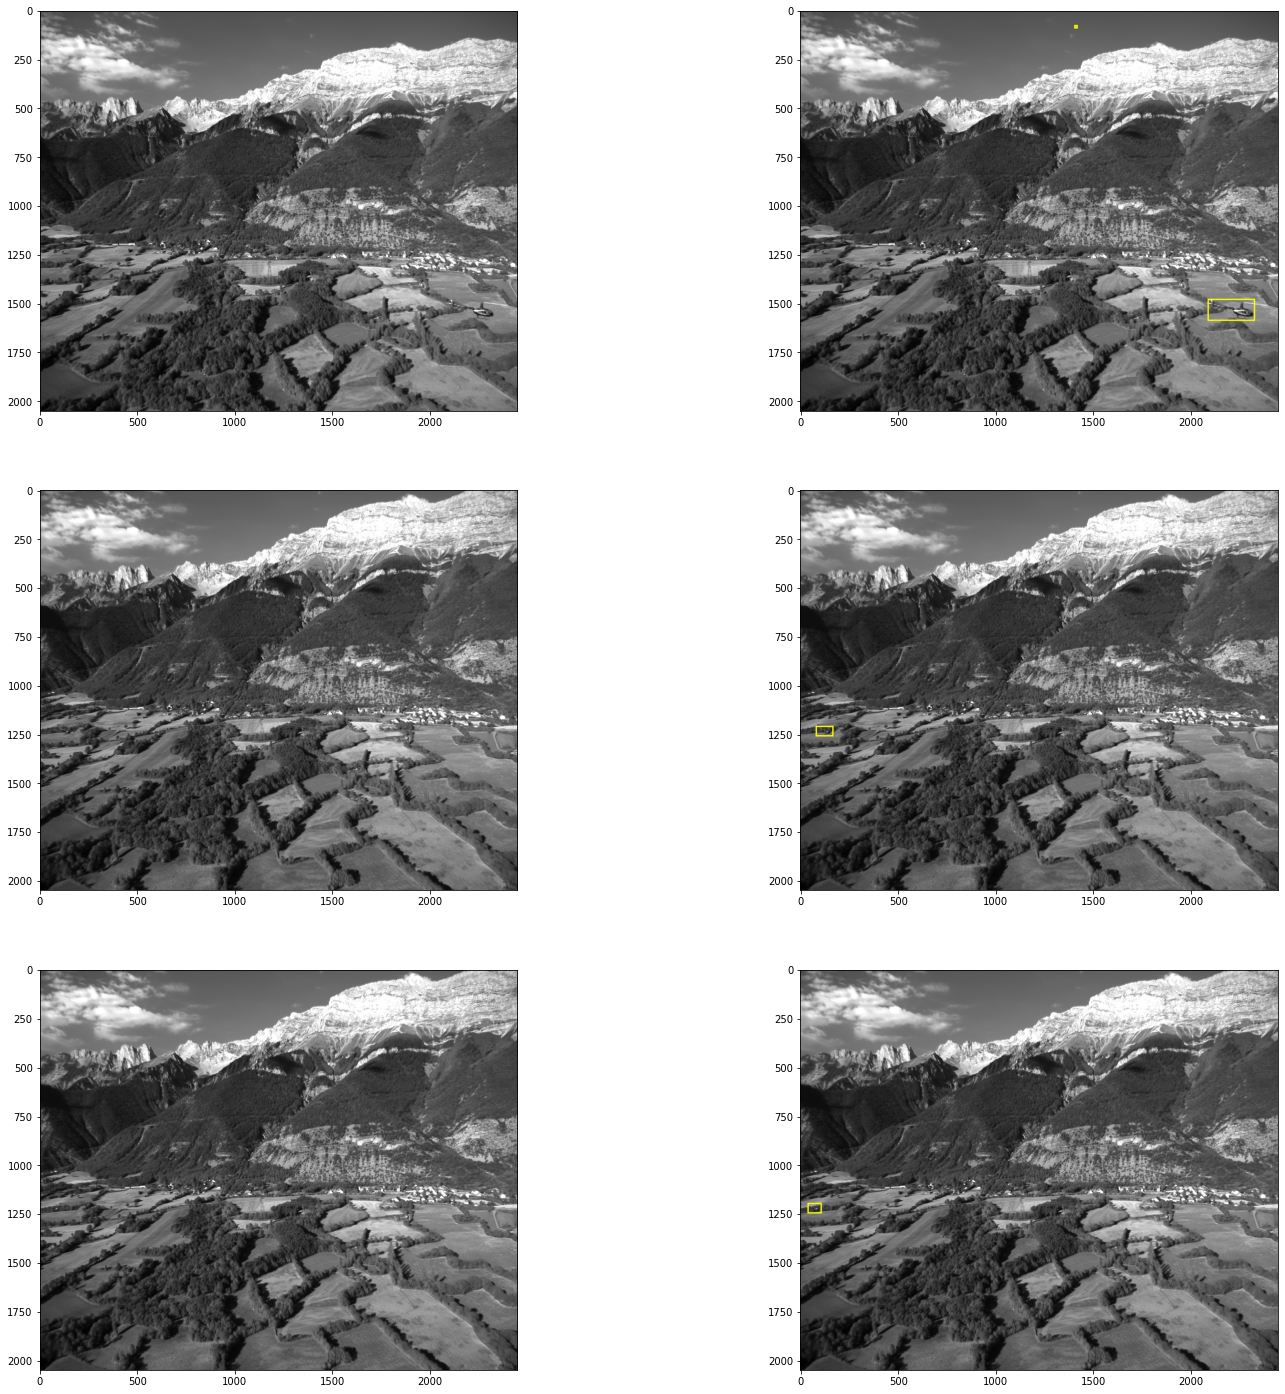

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25

import time

# Let's get one of the "planned" object in this video
airborne_objects = lucky_flight.detected_objects
obj_of_interest = None
for obj in airborne_objects:
    if airborne_objects[obj].planned:
        obj_of_interest = airborne_objects[obj]
        break

images = []
fig = plt.figure()


for i in range(1, 7, 2):
    frame = obj_of_interest.location[randrange(obj_of_interest.num_frames)].frame
    ax = fig.add_subplot(3, 2, i)
    ax.imshow(frame.image(type='cv2'))
    ax = fig.add_subplot(3, 2, i + 1)
    ax.imshow(frame.image_annotated())

plt.show()

In [11]:
flight_path = lucky_flight.generate_video(speed_x=1)

# For rendering on Colab
# Colab have certain restrictions due to which you can't video large video files directly, 
# but you can download instead...
from base64 import b64encode
mp4 = open(flight_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


# or you can download the video file..
# from google.colab import files
# files.download(flight_path) 

2021-08-24 12:50:07.473 | INFO     | core.flight:generate_video:129 - Generating video...


### Overall Distribution for Partial Dataset

*Please use `partial=True` for getting correct distributions below!*

#### ✈️ Airborne Objects Count Distribution

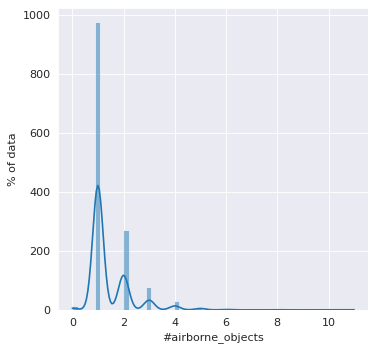

None

Avg:  1.4192614047791456
Min:  0
Max:  11


In [12]:
num_objects = []
for flight_id in dataset.get_flight_ids():
    num_objects.append(dataset.get_flight(flight_id).num_airborne_objs)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(num_objects, kde=True, bins=50)
plt.ylabel('% of data')
plt.xlabel('#airborne_objects')
display(plt.show())


print("Avg: ", sum(num_objects) / len(num_objects))
print("Min: ", min(num_objects))
print("Max: ", max(num_objects))

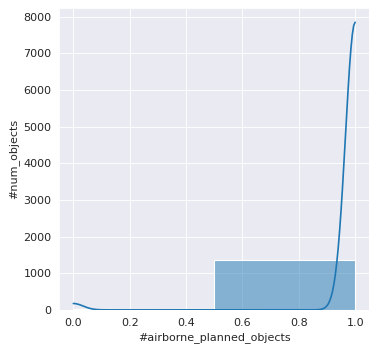

None

Min:  0
Max:  1


In [13]:
planned_num_objects = []
for flight_id in dataset.get_flight_ids():
    count = 0
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            count += 1
    
    planned_num_objects.append(count)
    
plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(planned_num_objects, kde=True, bins=2)
plt.ylabel('#num_objects')
plt.xlabel('#airborne_planned_objects')
display(plt.show())


print("Min: ", min(planned_num_objects))
print("Max: ", max(planned_num_objects))

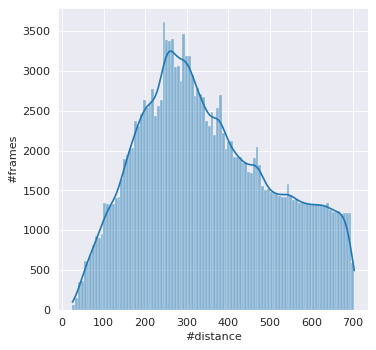

None

Avg:  355.2679551868107
Min:  25.047192232022347
Max:  703.4100199926818


In [14]:
obj_distance = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                obj_distance.append(loc.range_distance_m)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(obj_distance, kde=True, bins=100)
plt.ylabel('#frames')
plt.xlabel('#distance')
display(plt.show())

print("Avg: ", sum(obj_distance) / len(obj_distance))
print("Min: ", min(obj_distance))
print("Max: ", max(obj_distance))

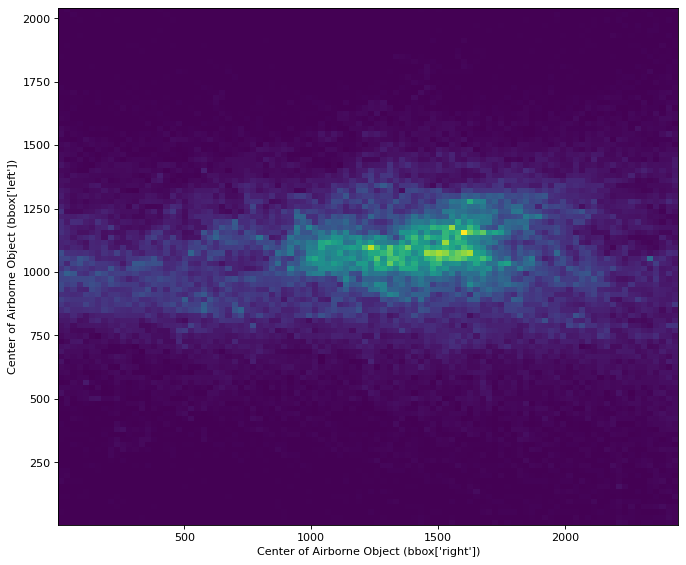

In [15]:
obj_center_left = []
obj_center_top = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left.append(left)
                obj_center_top.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left, obj_center_top, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.ylabel("Center of Airborne Object (bbox['left'])")
plt.xlabel("Center of Airborne Object (bbox['right'])")
plt.show()

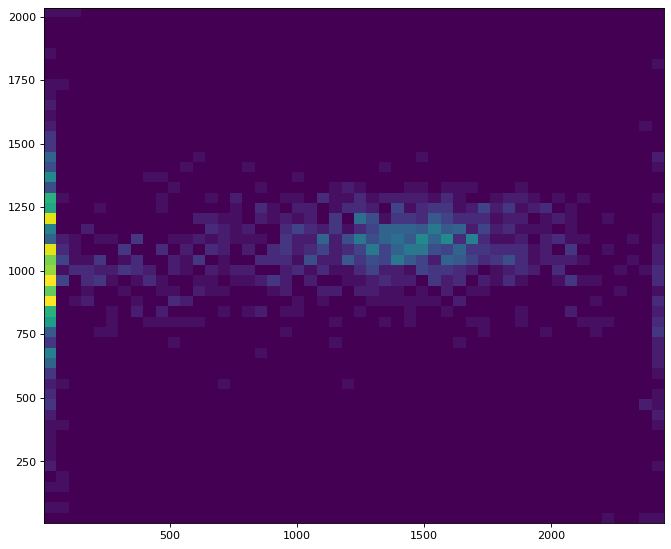

In [16]:
# Entry
# From where the Airborne objects generally start in whole flight
# Based on data it definitely looks like it come from left most of the times...

obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left_entry.append(left)
                obj_center_top_entry.append(top)
                break

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

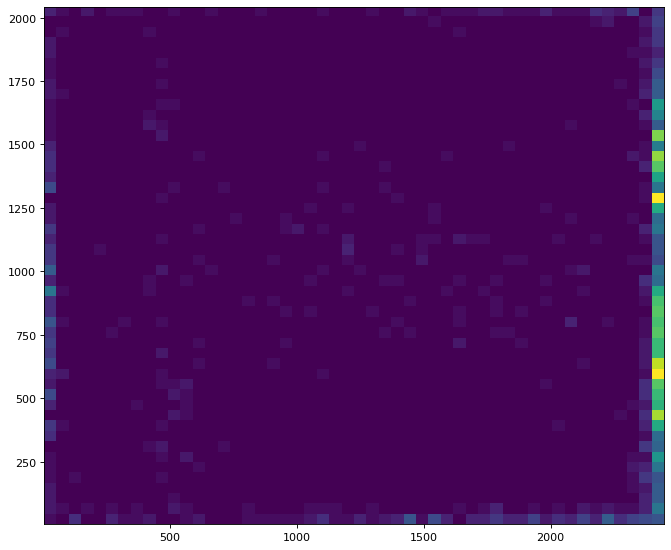

In [17]:
# Exit
# From where the Airborne objects generally exit in whole flight
# Based on data it definitely looks like it come from left and **leave** at right most of the times...
obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            loc = flight.detected_objects[obj].location[-1]
            left, top = loc.bb.get_center()
            obj_center_left_entry.append(left)
            obj_center_top_entry.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

### Overall Distribution

*Please use `partial=False` for getting correct distributions below!*

#### ✈️ Airborne Objects Count Distribution

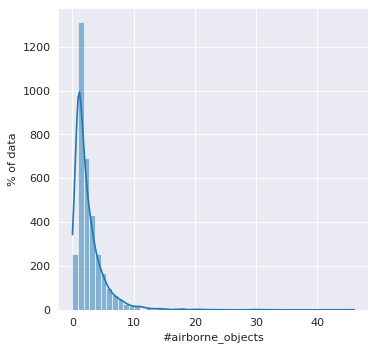

None

Avg:  2.5532286212914483
Min:  0
Max:  46


In [ ]:
num_objects = []
for flight_id in dataset.get_flight_ids():
    num_objects.append(dataset.get_flight(flight_id).num_airborne_objs)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(num_objects, kde=True, bins=50)
plt.ylabel('% of data')
plt.xlabel('#airborne_objects')
display(plt.show())


print("Avg: ", sum(num_objects) / len(num_objects))
print("Min: ", min(num_objects))
print("Max: ", max(num_objects))

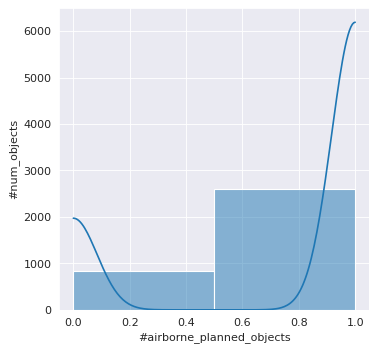

None

Min:  0
Max:  1


In [ ]:
planned_num_objects = []
for flight_id in dataset.get_flight_ids():
    count = 0
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            count += 1
    
    planned_num_objects.append(count)
    
plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(planned_num_objects, kde=True, bins=2)
plt.ylabel('#num_objects')
plt.xlabel('#airborne_planned_objects')
display(plt.show())


print("Min: ", min(planned_num_objects))
print("Max: ", max(planned_num_objects))

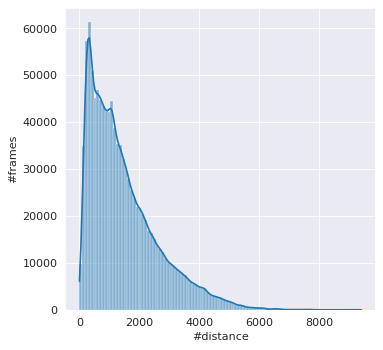

None

Avg:  1478.4207554675852
Min:  5.905805858280435
Max:  9399.925781456264


In [ ]:
obj_distance = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                obj_distance.append(loc.range_distance_m)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(obj_distance, kde=True, bins=100)
plt.ylabel('#frames')
plt.xlabel('#distance')
display(plt.show())

print("Avg: ", sum(obj_distance) / len(obj_distance))
print("Min: ", min(obj_distance))
print("Max: ", max(obj_distance))

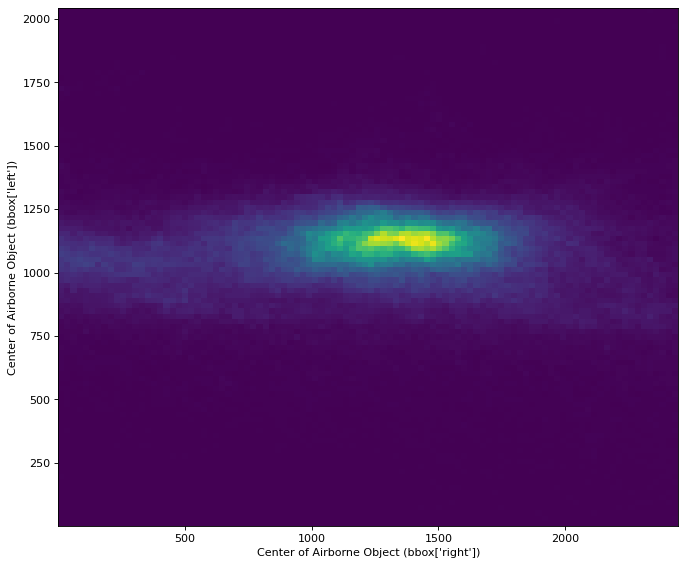

In [ ]:
obj_center_left = []
obj_center_top = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left.append(left)
                obj_center_top.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left, obj_center_top, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.ylabel("Center of Airborne Object (bbox['left'])")
plt.xlabel("Center of Airborne Object (bbox['right'])")
plt.show()

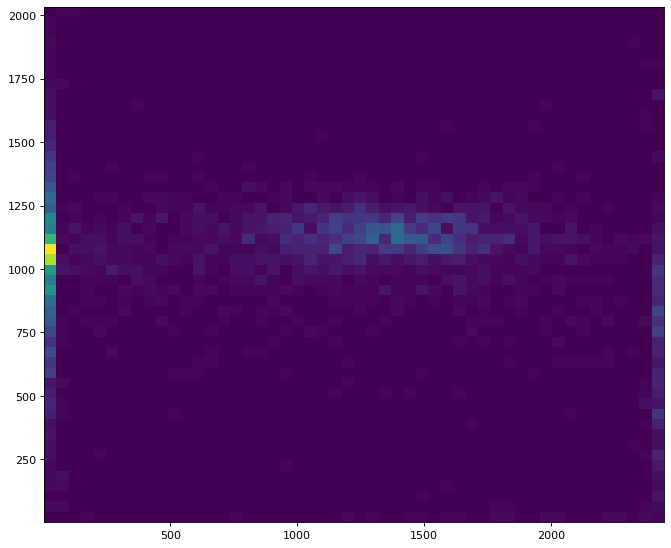

In [ ]:
# Entry
# From where the Airborne objects generally start in whole flight
# Based on data it definitely looks like it come from left most of the times...

obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left_entry.append(left)
                obj_center_top_entry.append(top)
                break

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

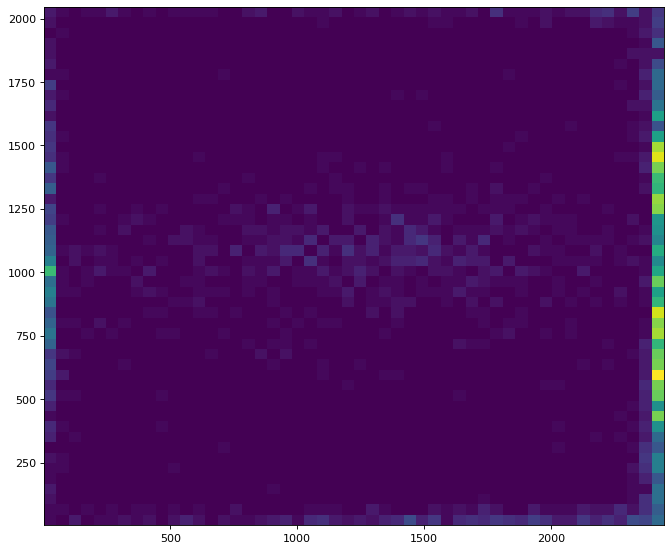

In [ ]:
# Exit
# From where the Airborne objects generally exit in whole flight
# Based on data it definitely looks like it come from left and **leave** at right most of the times...
obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            loc = flight.detected_objects[obj].location[-1]
            left, top = loc.bb.get_center()
            obj_center_left_entry.append(left)
            obj_center_top_entry.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

# _fin._

### We hope you had fun exploring data with us! 👋 

### You can fork this notebook to add more explorations.